In [29]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy


In [30]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'installment_rate', 'personal_status', 'debtors', 'residencesince', 'property', 'age', 'install_plans', 'housing', 'existing_credits', 'job', 'maintenance_paying_people', 'telephone', 'foreign_worker', 'result']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
df = pd.read_csv(url, delimiter=' ', names=cols, index_col=False)
df['result'] = df['result'].replace(2,0)

In [31]:
df.head()

,status,duration,credit_hist,purpose,credit_amt,savings,employment,installment_rate,personal_status,debtors,...,property,age,install_plans,housing,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [32]:
def preprocess_german(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)
    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    pd.get_dummies(df, columns=['purpose', 'housing'], drop_first=True)

    return df

In [33]:
df = preprocess_german(df)

In [34]:
df = df.drop(["purpose", "housing", "personal_status"], axis=1)
x = df[['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'installment_rate', 'debtors', 'residencesince',
       'property', 'age', 'install_plans', 'existing_credits', 'job',
       'maintenance_paying_people', 'telephone', 'foreign_worker',
       'gender']]

y = df['result']

In [35]:
len(y)

1000

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=15)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [37]:
x_test_orig = copy.deepcopy(x_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test_scalar = sc.fit_transform(x_test)
print(type(x_test_scalar))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [38]:
#calculate the influence of each train data point by retraining


In [39]:
#SCIKIT LEARN LR

# def demographic_parity(x_train, y_train, x_test, y_test):
#     # find the predictive probabilities for the protected and privileged groups based on 'age'
 
#     logistic_model = LogisticRegression(max_iter=1000)
#     logistic_model.fit(x_train, y_train.values.ravel())

#     x_test = x_test.reset_index(drop=True)
#     y_pred_proba = logistic_model.predict_proba(x_test)

#     privileged_gp_indices = x_test[x_test['age']==1].index
#     protected_gp_indices = x_test[x_test['age']==0].index

#     privileged_positive_pred = y_pred_proba[privileged_gp_indices, 1][y_pred_proba[privileged_gp_indices, 1] > 0.5].mean()
#     protected_positive_pred = y_pred_proba[protected_gp_indices, 1][y_pred_proba[protected_gp_indices, 1] > 0.5].mean()

#     return  privileged_positive_pred - protected_positive_pred


In [40]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)
    logistic_model = LogisticRegression(input_size=x_train_temp.shape[1], epoch_num=1000)
    logistic_model.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = logistic_model.predict_proba(x_test_scalar_temp)
    # print(y_pred_proba_temp.shape)
    # print(y_pred_proba_temp[0:10])

    privileged_gp_indices = x_test_temp[x_test_temp['age'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['age'] == 0].index
    # y_pred_proba returns an array, how do we know whether that is for the positive label or negative label.
    # assuming it gives us the probability of the positive class

    sum_pri = 0
    count_pri = 0
    for x in range(len(privileged_gp_indices)):
        # if y_pred_proba_temp[x] > 0.5:
        sum_pri += y_pred_proba_temp[x]
        count_pri += 1
    privileged_positive_pred = sum_pri/count_pri

    sum_pro = 0
    count_pro = 0
    for x in range(len(protected_gp_indices)):
        # if y_pred_proba_temp[x] > 0.5:
        sum_pro += y_pred_proba_temp[x]
        count_pro += 1
    protected_positive_pred = sum_pro/count_pro

    # privileged_positive_pred = y_pred_proba[privileged_gp_indices, 1][y_pred_proba[privileged_gp_indices, 1] > 0.5].mean()
    # protected_positive_pred = y_pred_proba[protected_gp_indices, 1][y_pred_proba[protected_gp_indices, 1] > 0.5].mean()

    return  protected_positive_pred - privileged_positive_pred

In [41]:
dp_ori = demographic_parity(x_train, y_train, x_test)

In [42]:
# find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# results are calculated and stored in a file, hence commented to save the train time for 800 iterations 

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

result = []

for i in range(len(x_train)):
    x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    result.append(demographic_parity(x_train_new, y_train_new, x_test) - dp_ori)

print(result)


[-0.00014627693418245435, 4.864785677427541e-05, 0.0004217128830346084, 0.00021078346068403864, -5.059888256053746e-06, 0.000350333842230488, 5.1239458208618416e-05, -9.236729245742925e-05, 0.00012857472261418312, 0.00018726413206593406, 0.0007336428794402217, -0.00026092513224140745, -3.495956683330359e-05, -0.00012130801982890294, -0.00015070393458838094, 3.6865579299716345e-05, 0.00017517098286778943, -0.0007989038849435248, 0.00022838942953484764, -6.672169691246399e-05, 0.00023195400224096385, -0.00016071390338812108, -4.0461484141829374e-05, 4.003194534130117e-05, -9.063204303816352e-05, -0.00010599031356961497, 0.00017783548283534234, 0.0006334035814080652, 0.0005175753837286523, -0.00020824287563581123, -0.0002810143955812583, -7.218707297251825e-06, -5.1608366033573105e-05, 0.0001911039744358911, 0.0003163436545111642, -4.813404266057475e-06, 0.00015005930202827145, 2.3901869214304483e-05, -6.144704409738466e-05, 0.0002105035531668742, -4.977288960328341e-05, 0.000122998067122

In [43]:
# np.save('trained_dp.npy', result)

In [44]:
clf = eval('LogisticRegression')(input_size=x_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [45]:
del_F_del_theta = del_spd_del_theta(clf, x_test_orig, x_test_scalar, y_test)
print(del_F_del_theta.shape)
print(type(del_F_del_theta))

(19,)
<class 'numpy.ndarray'>


In [46]:
hessian_all_points = get_hessian_all_points(clf, x_train, y_train, loss_func)


100%|██████████| 800/800 [00:03<00:00, 203.42it/s]


In [47]:
print(hessian_all_points.shape)

(800, 19, 19)


In [48]:
del_L_del_theta = get_del_L_del_theta(clf, x_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(800, 19)


In [49]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 


In [50]:
print(hinv_v.shape)

(19,)


df/d_epsi = df/d_theta * d_theta/d_epsi

d_theta/d_epsi = (1/n)* -H_inv * dL/d_theta 

df/d_theta = del_F_del_theta

In [51]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))  #it should be hessian* dL/d_theta 
# and then it should be multiplied by df/d_theta

In [52]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
print(inf.shape)

(800,)


In [53]:
print(type(inf))


<class 'numpy.ndarray'>


In [54]:
print(inf)

[ 6.60047819e-01  2.86622862e-02  3.55234343e-01 -2.17944766e-01
 -1.41005964e-01  2.44833179e+00 -6.27058409e-01 -3.86169881e-01
  5.22962519e-01  5.50220698e-02 -1.60809035e-01  1.88366730e-01
 -9.66759415e-01  2.59024972e+00 -7.94564990e-01 -4.41700946e-01
  1.43495995e-01 -7.44150980e-01  8.75735601e-01  3.92798521e-01
  5.13361244e-01 -3.44428670e-01 -8.75679132e-01 -1.51733820e+00
  1.06384067e-01  4.60973880e-01 -6.50034821e-01  3.31521132e-01
 -2.88079551e-02 -2.74110418e+00  3.48644602e+00  2.19575558e+00
 -1.52153718e-01 -4.15368798e-01 -9.24139671e-01  3.42318777e-01
 -8.91026442e-01 -6.05879104e-01 -7.96813193e-01  3.36812192e-01
 -3.92218726e-01  8.28730247e-01 -6.63641484e-01 -2.17897350e+00
  3.18819754e-01  3.77009517e-01 -3.79097209e-01 -1.05214122e+00
 -9.06217645e-01  6.02253466e-02 -9.25335472e-01 -7.41962332e-01
  4.84968230e-01  1.91548766e-01  2.93207708e+00  2.47656899e+00
 -1.08588676e+00 -9.19209953e-01  1.36434488e+00  2.25029317e+00
  2.95757444e+00 -9.42310

In [55]:
# result = np.load('trained_dp.npy')
# trained_arr = np.array(result)

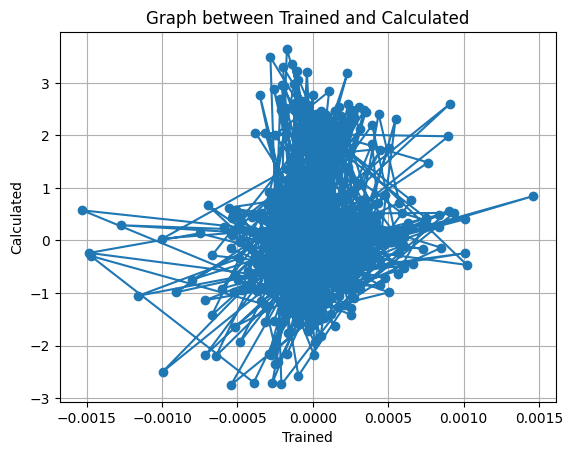

In [56]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'Trained': result, 'Calculated': inf})
plt.plot(df['Trained'], df['Calculated'], marker='o', linestyle='-')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained')
plt.ylabel('Calculated')
plt.grid(True)
plt.show()